In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import ast
import pickle
import sys
sys.path.insert(0, op.dirname(os.getcwd()))

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# tk 
from teslakit.project_site import Site
from teslakit.io.matlab import ReadGowMat
from teslakit.estela import Predictor
from teslakit.climate_emulator import Climate_Emulator


# --------------------------------------
# Site paths and parameters
site = Site('KWAJALEIN')

DB = site.pc.DB                        # common database
ST = site.pc.site                      # site database
PR = site.params                       # site parameters

# input files
p_wvs_parts = ST.WAVES.partitions_p1            # wave partitions (hs, tp)
p_wvs_fams_noTCs = ST.WAVES.families_notcs      # wave families (TCs removed)
p_kma_estela = op.join(ST.ESTELA.pred_slp, 'kma.nc')        # estela slp predictor KMA
p_wvs_fams_TCs_c = ST.WAVES.families_tcs_categ  # waves families at TCs time window by categories (folder)

p_dwt_sim = ST.ESTELA.sim_dwt                   # daily weather types simulated with ALR

# TCs simulation input files
p_sim_r2_params = ST.TCs.sim_r2_params          # TCs parameters (copula generated) 
p_sim_r2_RBF_output = ST.TCs.sim_r2_rbf_output  # TCs numerical_IH-RBFs_interpolation output
p_probs_synth = ST.TCs.probs_synth              # synthetic TCs probabilities
p_mutau_wt = ST.ESTELA.hydrog_mutau             # intradaily WTs mu,tau data folder


# climate emulator folder
p_ce = ST.EXTREMES.climate_emulator  


In [2]:
# --------------------------------------
# Load data for climate emulator fitting

# original wave partitions (hourly data)
xds_WVS_pts = ReadGowMat(p_wvs_parts)

# wave families (sea, swl1, swl2) without TCs
xds_WVS_fam = xr.open_dataset(p_wvs_fams_noTCs)

# ESTELA predictor KMA
xds_KMA = xr.open_dataset(p_kma_estela)


# Load DWTs sims data for climate emulator simulation
xds_DWT = xr.open_dataset(p_dwt_sim)

# Load TCs-window waves-families data by category\n",
d_WT_TCs_wvs = {}
for k in range(6):
    p_s = op.join(p_wvs_fams_TCs_c, 'waves_fams_cat{0}.nc'.format(k))
    d_WT_TCs_wvs['{0}'.format(k)] = xr.open_dataset(p_s)




# --------------------------------------
#  MATLAB TEST DATA    # TODO: delete

from teslakit.io.matlab import ReadMatfile
from teslakit.custom_dateutils import datevec2datetime as d2d
from teslakit.custom_dateutils import DateConverter_Mat2Py as dmp

# load test KMA (bmus, time, number of clusters, cenEOFs)
p_test_mat = '/Users/nico/Projects/TESLA-kit/source/data/tests/test_ExtremesGEV/Nico_Montecarlo/'
dmatf = ReadMatfile(op.join(p_test_mat, 'bmus_testearpython.mat'))
xds_KMA = xr.Dataset(
    {
        'bmus':('time', dmatf['KMA']['bmus']),
        'cenEOFs':(('n_clusters','n_features',), dmatf['KMA']['cenEOFs']),
    },
    coords = {'time':np.array(d2d(dmatf['KMA']['Dates']))}
)

# DWTs (Daily Weather Types simulated using ALR)
p_DWTs = op.join(p_test_mat, 'DWT_1000years_mjo_awt_v2.mat')
dm_DWTs = ReadMatfile(p_DWTs)
xds_DWT = xr.Dataset(
    {
        'evbmus_sims':(('time','n_sim'), dm_DWTs['bmusim'].T),
    },
)

# get WTs37,42 from matlab file
p_WTTCs = op.join(p_test_mat, 'KWA_waves_2PART_TCs_nan.mat')
dm_WTTCs = ReadMatfile(p_WTTCs)

# Load TCs-window waves-families data by category
d_WTTCs = {}
for i in range(6):

    k = 'wt{0}'.format(i+1+36)
    sd = dm_WTTCs[k]

    d_WTTCs['{0}'.format(i+1+36)] = xr.Dataset(
        {
            'sea_Hs':(('time',), sd['seaHs']),
            'sea_Dir':(('time',), sd['seaDir']),
            'sea_Tp':(('time',), sd['seaTp']),
            'swell_1_Hs':(('time',), sd['swl1Hs']),
            'swell_1_Dir':(('time',), sd['swl1Dir']),
            'swell_1_Tp':(('time',), sd['swl1Tp']),
            'swell_2_Hs':(('time',), sd['swl2Hs']),
            'swell_2_Dir':(('time',), sd['swl2Dir']),
            'swell_2_Tp':(('time',), sd['swl2Tp']),
        }
    )



In [3]:

# TODO: remove. Reducing DWT size for testing
xds_DWT = xds_DWT.isel(time=slice(0,1000))


In [4]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(p_ce)

# Waves and KMA bmus data share time dimension
xds_WVS_fam = xds_WVS_fam.sel(time=xds_KMA.time)
xds_WVS_pts = xds_WVS_pts.sel(time=xds_KMA.time)

# Fit extremes model
CE.FitExtremes(xds_KMA, xds_WVS_pts, xds_WVS_fam)


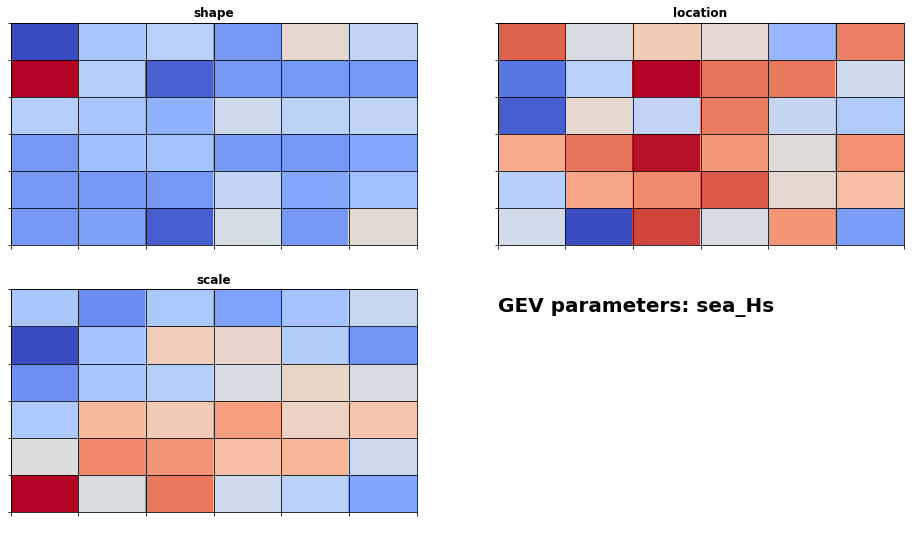

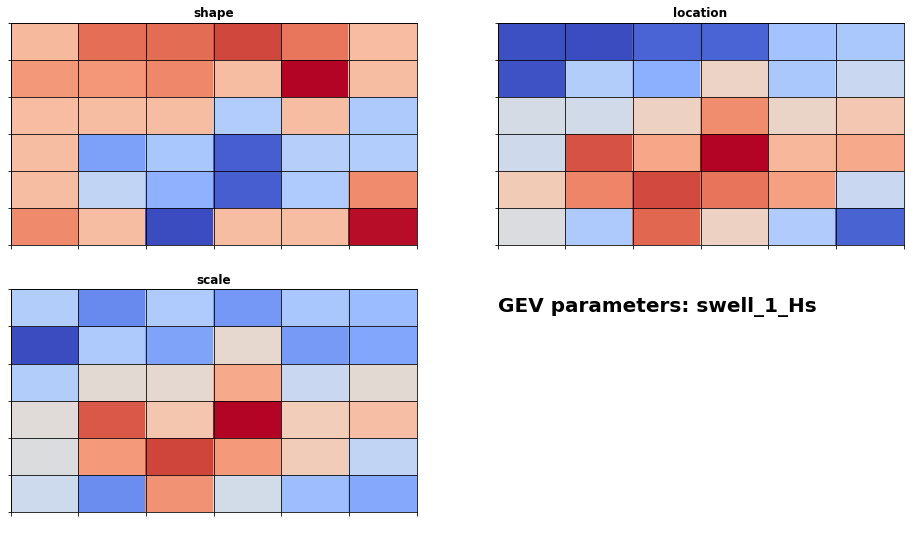

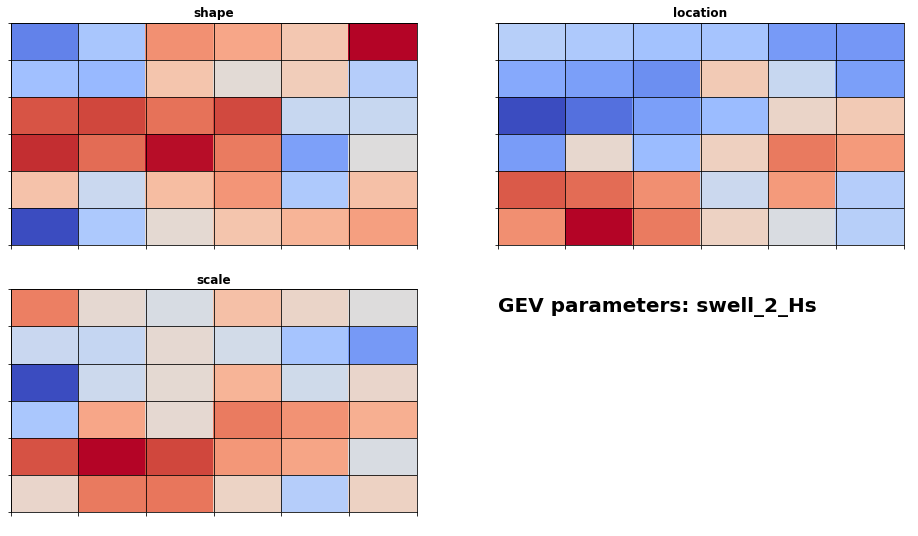

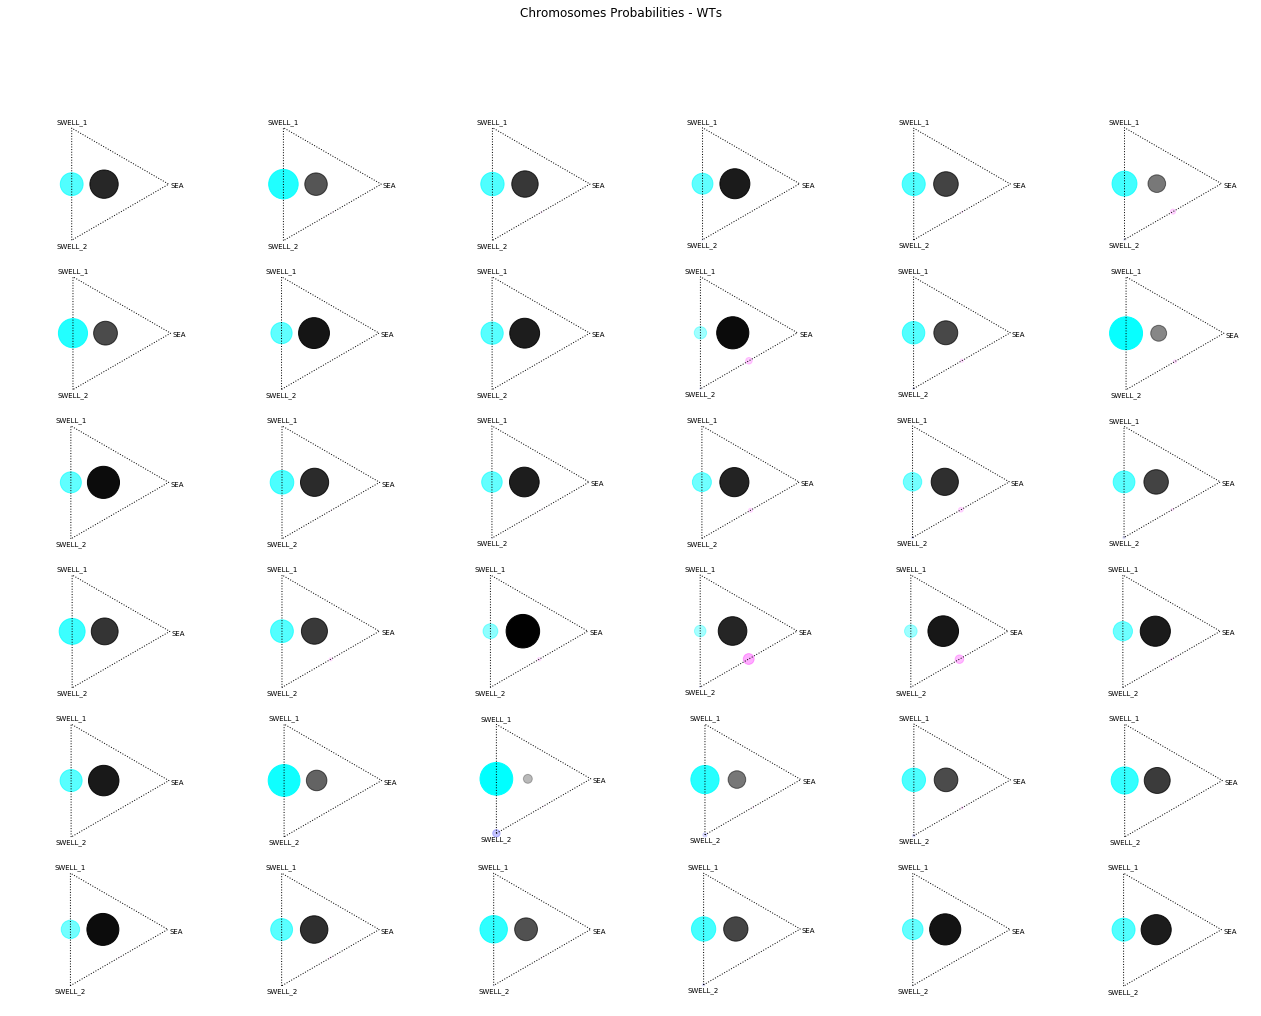

In [ ]:
# Fit report figures
CE = Climate_Emulator(p_ce)
CE.Load()
CE.Report_Fit()


In [ ]:
# --------------------------------------
#  Climate Emulator simulation (NO TCs)

# climate emulator object
CE = Climate_Emulator(p_ce)
CE.Load()

# Simulate waves
CE.Simulate_Waves(xds_DWT, d_WTTCs)


In [ ]:
# --------------------------------------
# Load data (needed to simulate WITH TCs)

# TCs simulated with numerical and RBFs (parameters and num/RBF output)
xds_TCs_params = xr.open_dataset(p_sim_r2_params)
xds_TCs_RBFs = xr.open_dataset(p_sim_r2_RBF_output)

# Synth. TCs probabilitie changues
xds_probs_TCs = xr.open_dataset(p_probs_synth)
pchange_TCs = xds_probs_TCs['category_change_cumsum'].values[:]

# MU - TAU intradaily hidrographs for each WWT
l_mutau_ncs = sorted(
    [op.join(p_mutau_wt, pf) for pf in os.listdir(p_mutau_wt) if pf.endswith('.nc')]
)
xdsets_mutau_wt = [xr.open_dataset(x) for x in l_mutau_ncs]

# get only MU and TAU numpy arrays
MU_WT = np.array([x.MU.values[:] for x in xdsets_mutau_wt])
TAU_WT = np.array([x.TAU.values[:] for x in xdsets_mutau_wt])


# --------------------------------------
#  TODO LOAD MATLAB TEST DATA
#p_mutaumat = op.join(p_test_mat, 'MU_TAU_36WT.mat')
#dm_MUTAU = ReadMatfile(p_mutaumat)
#print(dm_MUTAU)

In [ ]:
# --------------------------------------
#  Climate Emulator simulation (TCs)

# climate emulator object
CE = Climate_Emulator(p_ce)
CE.Load()

# Simulate TCs and update simulated waves
CE.Simulate_TCs(xds_DWT, d_WTTCs, xds_TCs_params, xds_TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)
